In [1]:
%pylab inline
import glob
import os
import numpy as np
import pandas as pd
import datetime as dt
import dateutil.parser
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
def convert(date):
    dt = dateutil.parser.parse(date).replace(tzinfo=None)
    epoch = dt.utcfromtimestamp(0)
    delta = dt - epoch
    return delta.total_seconds()

In [3]:
def pace(speed):
    miuntes, seconds = divmod(100 / (6 * speed), 1)
    seconds *= 60
    return (miuntes, seconds)

In [123]:
path = "/Users/aRa/OneDrive/Documentos/ERASMUS/PFC/SmartCoach/Running_w_HR/APE_runs_oct26-mar22"
colnames = np.array(['time', 'elevation', 'distance', 'speed', 'HR'])
means = []
medians = []
Datasets_all = []
os.chdir(path)
for file in glob.glob("*.tab"):
    ds = np.genfromtxt(file, skip_header=1, delimiter='\t', converters={0: convert})
    ds[:,0] -= ds[0,0]
      
#    if (ds[:,2].max() > 10000) == (ds[:,2].max() < 13000):
    ds = pd.DataFrame(ds,columns=colnames)
    dataset_new = ds.drop(['elevation','HR'], axis=1)
    Datasets_all.append(dataset_new)

        #RECALCULO DE LA VELOCIDAD PARA LA ACTIVITY_634112810
if len(Datasets_all) > 7:
    distances = np.array(Datasets_all[2].distance)
    times = np.array(Datasets_all[2].time)
    distance_diffs = np.concatenate([[distances[0]], distances[1:] - distances[:-1]])
    time_diffs = np.concatenate([[times[0]], times[1:] - times[:-1]])
    Datasets_all[2].speed = distance_diffs / time_diffs
    Datasets_all[2].replace(np.inf, np.nan, inplace=True)
    
len(Datasets_all)

14

In [124]:
speeds=[]
for x in range(len(Datasets_all)):
    datasets = pd.concat(Datasets_all[:x+1])
    datasets.sort('distance', inplace=True)
    speeds.append(datasets)
                           
median_speeds = [np.median(s.speed) for s in speeds]

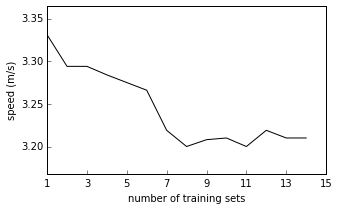

In [125]:
fig = plt.figure(figsize=(5,3), dpi=72)
ax = fig.add_subplot(111)
ax.plot(median_speeds,'k')
ax.set_ylim((min(median_speeds)*0.99, max(median_speeds)*1.01))
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_xticklabels([int(tick)+1 for tick in ax.get_xticks()])
ax.set_xlabel('number of training sets')
ax.set_ylabel('speed (m/s)')
if len(Datasets_all) > 7:
    fig.savefig('../../../Thesis/images/speedStabilization_all.pdf', bbox_inches='tight', dpi=fig.dpi)
else:
    fig.savefig('../../../Thesis/images/speedStabilization_filtered.pdf', bbox_inches='tight', dpi=fig.dpi)

In [14]:
datasets = pd.concat(Datasets_all,ignore_index=True)
datasets.sort(columns='distance', inplace=True)
datasets.index = np.arange(len(datasets))
print "Velocidad mediana training: {:.2f} m/s".format(datasets.speed.median())
print "Velocidad media training: {:.2f} m/s".format(datasets.speed.mean())
print "Mediana ritmo training {0:.0f}:{1:.0f} min/km".format(pace(datasets.speed.median())[0],pace(datasets.speed.median())[1])
print "Ritmo promedio training {0:.0f}:{1:.0f} min/km".format(pace(datasets.speed.mean())[0],pace(datasets.speed.mean())[1])

Velocidad mediana training: 3.17 m/s
Velocidad media training: 3.10 m/s
Mediana ritmo training 5:15 min/km
Ritmo promedio training 5:23 min/km


In [6]:
path = "/Users/aRa/OneDrive/Documentos/ERASMUS/PFC/SmartCoach/Running_w_HR/TEST/"
os.chdir(path)
for file in glob.glob("*.tab"):
    ds = np.genfromtxt(file, skip_header=1, delimiter='\t', converters={0: convert})
    ds[:,0] -= ds[0,0]
    ds = pd.DataFrame(ds,columns=colnames)

    print 'Distancia de la carrera {0} {1:.2f} km'.format(file[:-4], ds.distance.iloc[-1]/1000)
    print 'Tiempo real de carrera {}'.format(dt.timedelta(seconds=ds.time.iloc[-1]))
    print 'Tiempo estimado {} (mediana ritmo)'.format(dt.timedelta(seconds=round(ds.distance.iloc[-1]/datasets.speed.median()))), 
    print 'Error: {0} ({1:0.2f}%)\n'.format(dt.timedelta(seconds=abs(ds.time.iloc[-1] - round(ds.distance.iloc[-1]/datasets.speed.median()))),
                                           (ds.time.iloc[-1] - round(ds.distance.iloc[-1]/datasets.speed.median()))/ds.time.iloc[-1] * 100)

Distancia de la carrera feeling_bad_activity 10.01 km
Tiempo real de carrera 0:54:43
Tiempo estimado 0:52:36 (mediana ritmo) Error: 0:02:07 (3.87%)

Distancia de la carrera feeling_good_activity 11.00 km
Tiempo real de carrera 0:59:35
Tiempo estimado 0:57:48 (mediana ritmo) Error: 0:01:47 (2.99%)

Distancia de la carrera Morat_Fribourg2014 17.18 km
Tiempo real de carrera 1:32:14
Tiempo estimado 1:30:17 (mediana ritmo) Error: 0:01:57 (2.11%)

Distancia de la carrera test_activity 11.41 km
Tiempo real de carrera 1:00:01
Tiempo estimado 0:59:58 (mediana ritmo) Error: 0:00:03 (0.08%)



In [7]:
path = "/Users/aRa/OneDrive/Documentos/ERASMUS/PFC/SmartCoach/Running_w_HR/TEST/"
os.chdir(path)
file = 'test_activity.tab'
validation_data = np.genfromtxt(file, skip_header=1, delimiter='\t', converters={0: convert})
validation_data[:,0] -= validation_data[0,0]
validation_data = pd.DataFrame(validation_data,columns=colnames)
distances = np.array(validation_data.distance)
distance_diffs = np.concatenate([[distances[0]], distances[1:] - distances[:len(distances)-1]])

time_runner = np.array(validation_data.time)
time_diffs = np.concatenate([[time_runner[0]], time_runner[1:] - time_runner[:len(time_runner)-1]])
times_prediction = distance_diffs / datasets.speed.median()
times_prediction[0] = 0
times = np.arange(len(time_runner))
rt = np.vectorize(lambda x: times_prediction[x:].sum(axis=0))
t = np.vectorize(lambda x: times_prediction[:x+1].sum(axis=0))
times_estimated_total = np.concatenate([[0], time_runner[:-1]]) + times_prediction
remaining_time = rt(times)
total_time = time_runner + remaining_time
total_predicted = t(times)
validation_data.head()

,time,elevation,distance,speed,HR
0,0,716.400024,1.520000,0.000,98
1,1,716.400024,2.370000,1.549,99
2,3,716.000000,7.170000,1.577,103
3,5,716.400024,12.560000,2.463,106
4,8,717.599976,21.040001,2.734,109


In [8]:
if file == 'test_activity.tab':
    test = pd.DataFrame({'Distance': distances,
                              '$\Delta{}d$': distance_diffs,
                              'Elevation': validation_data.elevation,
                              'Speed': validation_data.speed,
                              'Time Runner': time_runner,
                              '$\Delta{}t^{est}$': times_prediction,
                              '$\Delta{}t^{real}$': time_diffs,
                              'Remaining Time': remaining_time,
                              'Total time': total_time,
                              'Total predicted': total_predicted,
                              'Time estimated': times_estimated_total})
    test.to_pickle('cs1_test')
    print file
    print test.head()

elif file == 'feeling_bad_activity.tab':
    feelingBad = pd.DataFrame({'Distance': distances,
                              '$\Delta{}d$': distance_diffs,
                              'Elevation': validation_data.elevation,
                              'Speed': validation_data.speed,
                              'Time Runner': time_runner,
                              '$\Delta{}t^{est}$': times_prediction,
                              '$\Delta{}t^{real}$': time_diffs,
                              'Remaining Time': remaining_time,
                              'Total time': total_time,
                              'Total predicted': total_predicted,
                              'Time estimated': times_estimated_total})
    feelingBad.to_pickle('cs1_feelingBad')
    print file
    print feelingBad.head()

elif file == 'Morat_Fribourg2014.tab':
    moratFribourg = pd.DataFrame({'Distance': distances,
                              '$\Delta{}d$': distance_diffs,
                              'Elevation': validation_data.elevation,
                              'Speed': validation_data.speed,
                              'Time Runner': time_runner,
                              '$\Delta{}t^{est}$': times_prediction,
                              '$\Delta{}t^{real}$': time_diffs,
                              'Remaining Time': remaining_time,
                              'Total time': total_time,
                              'Total predicted': total_predicted,
                              'Time estimated': times_estimated_total})
    moratFribourg.to_pickle('cs1_morFrib')
    print file
    print moratFribourg.head()

test_activity.tab
   $\Delta{}d$  $\Delta{}t^{est}$  $\Delta{}t^{real}$   Distance   Elevation  \
0         1.52           0.000000                   0   1.520000  716.400024   
1         0.85           0.267970                   1   2.370000  716.400024   
2         4.80           1.513241                   2   7.170000  716.000000   
3         5.39           1.699244                   2  12.560000  716.400024   
4         8.48           2.673392                   3  21.040001  717.599976   

   Remaining Time  Speed  Time Runner  Time estimated  Total predicted  \
0     3597.604150  0.000            0        0.000000         0.000000   
1     3597.604150  1.549            1        0.267970         0.267970   
2     3597.336180  1.577            3        2.513241         1.781211   
3     3595.822939  2.463            5        4.699244         3.480454   
4     3594.123696  2.734            8        7.673392         6.153847   

    Total time  
0  3597.604150  
1  3598.604150  
2  36

In [2]:
path = "/Users/aRa/OneDrive/Documentos/ERASMUS/PFC/SmartCoach/Running_w_HR/TEST/"
os.chdir(path)
test = pd.read_pickle('cs1_test')
feelingBad = pd.read_pickle('cs1_feelingBad')
moratFribourg = pd.read_pickle('cs1_morFrib')

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid

def add_inner_title(ax, title, loc, size=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    from matplotlib.patheffects import withStroke
    if size is None:
        size = dict(size=plt.rcParams['legend.fontsize'])
    at = AnchoredText(title, loc=loc, prop=size,
                      pad=0., borderpad=0.5,
                      frameon=False, **kwargs)
    ax.add_artist(at)
    at.txt._text.set_path_effects([withStroke(foreground="w", linewidth=3)])
    return at

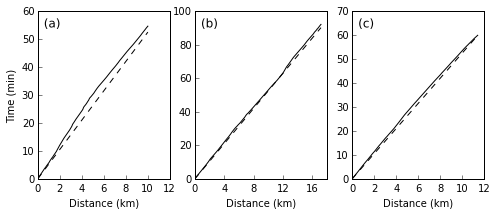

In [4]:
# REAL TIME VS PREDICTED TIME
fig = plt.figure(figsize=(8,3), dpi=72)
ax1 = fig.add_subplot(111)
divider = make_axes_locatable(ax1)
ax2 = divider.new_horizontal(size="100%", pad=0.35)
ax3 = divider.new_horizontal(size="100%", pad=0.35)

fig1 = ax1.get_figure()
fig1.add_axes(ax2)
fig1.add_axes(ax3)

ax1.plot(feelingBad['Distance']/1000, feelingBad['Time Runner']/60, 'k', label='Race time')
ax1.plot(feelingBad['Distance']/1000, feelingBad['Total predicted']/60, 'k--', label='Predicted time')
ax2.plot(moratFribourg['Distance']/1000, moratFribourg['Time Runner']/60, 'k', label='Race time')
ax2.plot(moratFribourg['Distance']/1000, moratFribourg['Total predicted']/60, 'k--', label='Predicted time')
ax3.plot(test['Distance']/1000, test['Time Runner']/60, 'k', label='Race time')
ax3.plot(test['Distance']/1000, test['Total predicted']/60, 'k--', label='Predicted time')
ax1.set_ylabel('Time (min)')

#fig.legend(loc='best')
for ax, im_title in zip([ax1, ax2, ax3], ["(a)", "(b)", "(c)"]):
        t = add_inner_title(ax, im_title, loc=2)
        t.patch.set_ec("none")
        t.patch.set_alpha(0.5)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel('Distance (km)')
ax2.set_xticks(ax2.get_xticks()[::2])   
plt.savefig('../../../Thesis/images/TimeRunnerVsTimePredictedCS1.pdf',bbox_inches='tight', dpi=fig.dpi)
plt.draw()
plt.show()

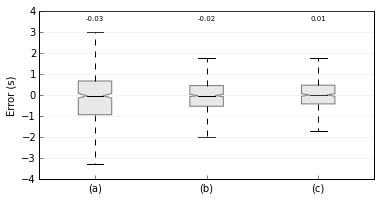

In [12]:
# BOXPLOTS ERRORES DE PREDICCIÓN
errorFeelingBad = feelingBad['$\Delta{}t^{est}$'] - feelingBad['$\Delta{}t^{real}$']
errorMoratFrib = moratFribourg['$\Delta{}t^{est}$'] - moratFribourg['$\Delta{}t^{real}$'] 
errorTest = test['$\Delta{}t^{est}$'] - test['$\Delta{}t^{real}$']
errors = [errorFeelingBad, errorMoratFrib, errorTest]
numBoxes = len(errors)
pos = np.arange(numBoxes)+1

fig = plt.figure(figsize=(6,3), dpi=72)
ax = fig.add_subplot(111)
bp = ax.boxplot(errors, labels=['(a)', '(b)', '(c)'], patch_artist=True, sym='', notch=True)

plt.setp(bp['boxes'], color='black', facecolor = 'lightgrey', alpha=0.5)
plt.setp(bp['medians'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['caps'], color='black')

top = ax.get_ylim()[1]*0.89
medians = [np.nanmedian(i) for i in errors]
upperLabels = [str(np.round(s, 2)) for s in medians]

for tick,label in zip(range(numBoxes),ax1.get_xticklabels()):
    ax.text(pos[tick], top, upperLabels[tick], horizontalalignment='center', size='x-small', color='black')

ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_ylabel('Error (s)')
plt.savefig('../../../Thesis/images/bxplotErrorsCS1.pdf',bbox_inches='tight', dpi=fig.dpi)

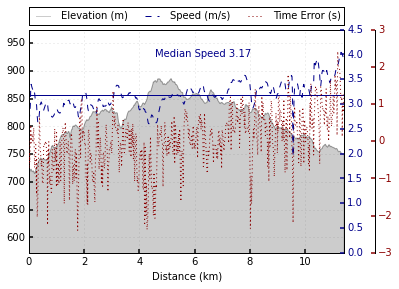

In [37]:
# GRAFICA DEL ERROR DE PREDICCION CON ELEVACION Y VELOCIDAD
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.itervalues():
        sp.set_visible(False)
        
fig, host = plt.subplots(figsize=(7,4), dpi=72)
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

par2.spines["right"].set_position(("axes", 1.1))
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)

p1, = host.plot(test['Distance'], test['Elevation'], color='k', label='Elevation (m)',alpha=0.2)
host.fill_between(test['Distance'], 0, test['Elevation'], color='k', alpha=0.2)
p2, = par1.plot(test['Distance'], test['Speed'], color='DarkBlue', linestyle='--', label='Speed (m/s)')
p2.axes.axhline(y=datasets.speed.median(), color='DarkBlue')
p3, = par2.plot(test['Distance'], test['$\Delta{}t^{est}$'] - test['$\Delta{}t^{real}$'], 
                color='DarkRed', linestyle=':', label=r'Time Error (s)')

host.set_xlim([test['Distance'].min(), test['Distance'].max()])
host.set_xticklabels([np.str(int(i)) for i in host.get_xticks()/1000])
host.set_ylim([test['Elevation'].min()*0.8, test['Elevation'].max()*1.1])

host.set_xlabel(r'Distance (km)')

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)
host.get_xaxis().tick_bottom()
host.legend((p1, p2, p3),(p1.get_label(), p2.get_label(), p3.get_label()),
           bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.,
            fontsize=10)
host.grid(alpha=0.25)
host.text(0.4*host.get_xlim()[-1],0.95*host.get_ylim()[-1],
          'Median Speed {:.2f}'.format(datasets.speed.median()), color='DarkBlue', fontsize=10)
fig.savefig("../../../Thesis/images/errorCS1Test.pdf", bbox_inches='tight', dpi=fig.dpi)

NameError: name 'distances' is not defined

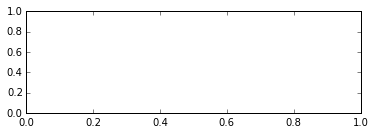

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
im=ax1.plot(distances,validation_data.elevation,'k',zorder=1)
ax1.set_title('Elevation',fontsize=16,y=1.02)
ax1.set_ylabel('Elevation ['r'$m$]')
ax1.grid(axis='y', alpha=0.5)
ax1.set_yticks(ax1.get_yticks()[::2])
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(212)
ax2.plot(distances, times_prediction_total,c='black',zorder=1)
#ax2.scatter(laps,laps_times_total-0.1,c='white',zorder=1,linewidth=0)
ax2.axhline(y=time_runner[-1]/60, color='magenta')
ax2.text(0.95,0.95,'Real time {}'.format(dt.timedelta(seconds=time_runner[-1])), 
         verticalalignment='top', horizontalalignment='right', transform=ax2.transAxes,
         color='magenta', fontsize=14)
ax2.set_title('Estimated time',fontsize=16,y=1.02)
ax2.set_xlabel('Distance ['r'$m$]')
ax2.set_ylabel('Time ['r'$min$]')
ax2.grid(alpha=0.5)
ax2.set_ylim([time_min - (time_max-time_min)/2., time_max + (time_max-time_min)/2])
ax2.set_yticks(ax2.get_yticks()[::2])
ax2.set_xticks(np.arange(-2000,14000, 2000))
ax1.set_xlim(ax2.get_xlim())
plt.tight_layout()

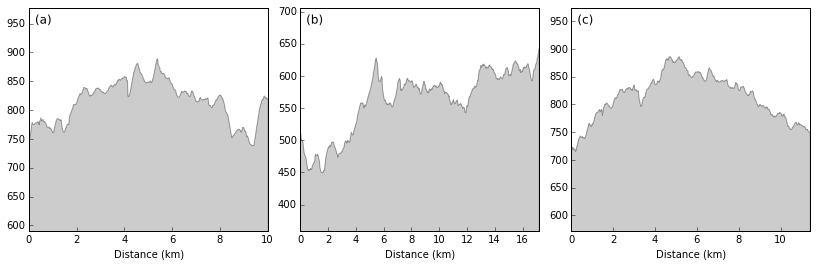

In [8]:
Distances = [feelingBad['Distance'], moratFribourg['Distance'], test['Distance']]
Elevations = [feelingBad['Elevation'], moratFribourg['Elevation'], test['Elevation']]

fig = plt.figure(figsize=(14,4), dpi=72)
ax1 = fig.add_subplot(111)
divider = make_axes_locatable(ax1)
ax2 = divider.new_horizontal(size="100%", pad=0.45)
ax3 = divider.new_horizontal(size="100%", pad=0.45)

fig1 = ax1.get_figure()
fig1.add_axes(ax2)
fig1.add_axes(ax3)

ax1.plot(feelingBad['Distance'], feelingBad['Elevation'], color='k', label='Elevation (m)',alpha=0.2)
ax1.fill_between(feelingBad['Distance'], 0, feelingBad['Elevation'], color='k', alpha=0.2)
ax1.set_xlim([feelingBad['Distance'].min(), feelingBad['Distance'].max()])
ax1.set_ylim([feelingBad['Elevation'].min()*0.8, feelingBad['Elevation'].max()*1.1])

ax2.plot(moratFribourg['Distance'], moratFribourg['Elevation'], color='k', label='Elevation (m)',alpha=0.2)
ax2.fill_between(moratFribourg['Distance'], 0, moratFribourg['Elevation'], color='k', alpha=0.2)
ax2.set_xlim([moratFribourg['Distance'].min(), moratFribourg['Distance'].max()])
ax2.set_ylim([moratFribourg['Elevation'].min()*0.8, moratFribourg['Elevation'].max()*1.1])

ax3.plot(test['Distance'], test['Elevation'], color='k', label='Elevation (m)',alpha=0.2)
ax3.fill_between(test['Distance'], 0, test['Elevation'], color='k', alpha=0.2)
ax3.set_xlim([test['Distance'].min(), test['Distance'].max()])
ax3.set_ylim([test['Elevation'].min()*0.8, test['Elevation'].max()*1.1])

for ax, im_title in zip([ax1, ax2, ax3], ["(a)", "(b)", "(c)"]):
        t = add_inner_title(ax, im_title, loc=2)
        t.patch.set_ec("none")
        t.patch.set_alpha(0.5)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xticklabels([np.str(int(i)) for i in ax.get_xticks()/1000])
        ax.set_xlabel('Distance (km)')
fig.savefig("../../../Thesis/images/Elevations.pdf", bbox_inches='tight', dpi=fig.dpi)